# Smash Bros Tier List 

In [1]:
import pickle
import pandas as pd 
from nltk.corpus import stopwords
import nltk #nlp intro book
from scipy.sparse import coo_matrix 
import re
import string
import matplotlib.pyplot as plt 
%matplotlib inline 

#NLP modules
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem import WordNetLemmatizer#, LemmaTokenizer

#word2vec
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
    
#Corex
from corextopic import corextopic as ct
from corextopic import vis_topic as vt

#TSNE
from sklearn.manifold import TSNE

#download if need more
#nltk.download()

### Extract data from MongoDB and create a Dataframe of unique posts 

In [2]:
#RUN ONLY 1 TIME
from pymongo import MongoClient
client = MongoClient()
db = client.Smash_tweets
mega_mongo = list(db.Smash_posts.find({}, {'_id':0})) #remove 5 for entire thing
print(len(mega_mongo))

#create duplicates
df = pd.DataFrame(list(db.Smash_posts.find({}, {'_id':0})))
print("Shape before dropping the dups: ", df.shape)
df.drop_duplicates(inplace=True) ###remove duplicates if there were multiple runs
print("Shape after dropping the dups: ", df.shape)


121178
Shape before dropping the dups:  (121178, 4)
Shape after dropping the dups:  (118632, 4)


In [ ]:
#save dataframe for later use
with open('main_df.pkl', 'wb') as picklefile:
    pickle.dump(df, picklefile)

### Prep work for processing

In [2]:
#map characters and different spellings/nicknames to standardized name so can use later on 
character_map = {
"donkey kong":"donkey_kong", "dark samus":"dark_samus", "captain falcon":"captain_falcon", "ice climbers":"ice_climbers",
"dr  mario":"dr__mario", "young link":"young_link", "mr  game   watch":"mr__game___watch", 
"game   watch":"mr__game___watch", "meta knight":"meta_knight", "metaknight":"meta_knight", "dark pit":"dark_pit",
"zero suit samus":"zero_suit_samus", "zss":"zero_suit_samus", "pokémon trainer":"pokemon_trainer",
"pokemon trainer":"pokemon_trainer", "diddy kong":"diddy_kong", "king dedede":"king_dedede", "dedede":"king_dedede",
"toon link":"toon_link", "mega man":"mega_man", "megaman":"mega_man", "wii fit trainer":"wii_fit_trainer",
"rosalina   luma":"rosalina___luma", "rosalina":"rosalina___luma", "little mac":"little_mac", 
"mii brawler":"mii_brawler", "mii swordfighter":"mii_swordfighter", "mii gunner":"mii_gunner", "pac man":"pac_man",
"pacman":"pac_man", "bowser jr":"bowser_jr", "duck hunt":"duck_hunt", "duckhunt":"duck_hunt",
"king k  rool":"king_k__rool", "piranha plant":"piranha_plant", "banjo   kazooie":"banjo___kazooie",
"rosalina___luma___luma": "rosalina___luma", "king_king_dedede": "king_dedede", "bayo": "bayonetta",
"gannon": "ganondorf", "ganon": "ganondorf"
}

#total character list as mapped above
character_list = [
"donkey_kong", "dark_samus", "captain_falcon", "ice_climbers", "dr__mario", "young_link", "mr__game___watch",
"meta_knight", "dark_pit", "zero_suit_samus", "squirtle", "ivysaur", "charizard", "pokemon_trainer", "diddy_kong",
"king_dedede", "toon_link", "mega_man", "wii_fit_trainer", "rosalina___luma", "little_mac", "mii_brawler",
"mii_swordfighter", "mii_gunner", "pac_man", "bowser_jr", "duck_hunt", "king_k__rool", "piranha_plant", 
"banjo___kazooie", "mario", "link", "samus", "yoshi", "kirby", "fox", "pikachu", "luigi", "ness", "jigglypuff",
"peach", "daisy", "bowser", "sheik", "zelda", "pichu", "falco", "marth", "lucina", "ganondorf", "mewtwo", "roy",
"chrom", "pit","wario", "snake", "ike", "lucas", "sonic", "olimar", "lucario", "rob", "wolf", "villager", "greninja",
"palutena", "robin", "shulk", "ryu", "ken", "cloud", "corrin", "bayonetta", "inkling", "ridley", "simon", "richter",
"isabelle", "incineroar", "joker","hero"
]

In [4]:
# general stats about data sets
print("shape of df", df.shape)
print("# of topics", df['Topic_Title'].nunique())

shape of df (118632, 4)
# of topics 4973


### NLP preprocessing - Cleaning Text & Standardizing 

In [3]:
#one time processing step to remove quote strings, non-alphanumeric 
#map character names that involve spaces to retain character names 

#run to reprocess the original dataframe gotten from MongoDB
with open('main_df.pkl', 'rb') as picklefile:
    df = pickle.load(picklefile)

quote_text = (lambda x: re.sub(r'.+? posted...', '', x)) #get rid of quotes "user posted string"
#above assumes that there are not instances of multi quotes in the post..

punc_lower = (lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())) #get rid of punctuation+lower

#get rid of non-alphanumeric characters
alphanumeric = (lambda x: re.sub('\w*\d\w*', ' ', x)) #remove non alpha numeric values

df['Post'] = df['Post'].map(quote_text).map(punc_lower).map(alphanumeric)

for key, value in character_map.items(): #works through each key in replacement dict to standardize character names 
    df['Post'] = df['Post'].str.replace(key, value) 

#save the processed df for later use
with open('main_df_processed.pkl', 'wb') as picklefile:
    pickle.dump(df, picklefile)


In [4]:
df.tail(7) #preview

,Link,Page_Num,Post,Topic_Title
121171,https://gamefaqs.gamespot.com/boards/234547-su...,1,i love yoshi so cute and fun i don t play hi...,Community Character Consensus #05: Yoshi
121172,https://gamefaqs.gamespot.com/boards/234547-su...,1,i don t hate yoshi but i don t like playing a...,Community Character Consensus #05: Yoshi
121173,https://gamefaqs.gamespot.com/boards/234547-su...,2,i love yoshi he s super cute and one of my fa...,Community Character Consensus #05: Yoshi
121174,https://gamefaqs.gamespot.com/boards/234547-su...,2,yoshi is a beast in ultimate try fighting a ...,Community Character Consensus #05: Yoshi
121175,https://gamefaqs.gamespot.com/boards/234547-su...,2,nes mettaur care to share your thoughts on yo...,Community Character Consensus #05: Yoshi
121176,https://gamefaqs.gamespot.com/boards/234547-su...,2,yoshi exists he ll periodically interest m...,Community Character Consensus #05: Yoshi
121177,https://gamefaqs.gamespot.com/boards/234547-su...,2,i love using yoshi him ganondorf mr__game_...,Community Character Consensus #05: Yoshi


### NLP stop words

In [5]:
#creating the normal stop word dict
default_stop = list(set(stopwords.words('english')))

#custom stop word list based on output from model runs/ EDA
dan_stop = ['post', 'bump', 'lol', 'lmao', 'rofl', 'iirc', 'ftw', 'https', 'http', 'url', 'youtu', 'youtube', 'yeah', 
            'yea', 'https', 'wordpress', 'com', 'imgur', 'bsans', 'mega_manssbu', 'dlc', 'dlcs', 'ssbu',
           'archiveofourown','thespinnerisawesome','themindgamerhttp','themindgamer','thehungryboxthe','kommo',
           'www', 'tinyurl', 'thehungryboxthe', 'samusdark_samusjokerlinkganon','luigibowserbayonettakirbya',
           'richterdonkey_kongdiddy_kongpikachuikechrommarthpokemon_trainer', 'roolzeldasimond',
           'lumassonicnessmario', 'wolfryu', 'cilmberswii_fit_trainervillager', 'lumassonicnessmario',
            'mr__game___watcholimar','cilmberswii_fit_trainervillager', 'wolfryu','piranha_plantice',
           'isabelleduck_hunt','linkganonherodonkey_kongikepikachucorrinchromroymarthlucinazeldad',
           'kengreninjaincineroarinklingslittle_mace', 'miismr','luigibowserbayonettaa', 'jpg',
            'pitpalutenadark_pitmega_mancloudlucasmewtwob', 
            'warioridleymeta_knightking_dededepeachrobinpac_man', 'corrinroylucinaking'
           ]
maybe_stops = ['melee', 'brawl', 'ssb']

#final stop word dictionary
stop_all = default_stop + dan_stop

### NLP Preprocessing - Lemmatization/Tokenization

In [6]:
#create pandas series of just the posts
df_posts = df['Post'].astype(str) #coerce into str to make sure

In [7]:
#just lemmatize posts
lemmatizer = nltk.stem.WordNetLemmatizer()
lemm_posts = df_posts.apply(lambda x : lemmatizer.lemmatize(x)) #used for tf-idf

In [8]:
final_posts = lemm_posts.apply(nltk.word_tokenize) #use for word2vec

In [9]:
#creates a standard version of the posts that is suitable for input into word2vec
clean_posts = []
for line in final_posts:
    line_list = []
    for word in line:
        if word not in stop_all: 
            line_list.append(word)
    clean_posts.append(line_list)

In [10]:
final_posts = clean_posts.copy()

### NLP TF-IDF / Count Vectorization (used to get stop words figure out issues)

In [10]:
tf_vec = TfidfVectorizer(stop_words=stop_all, min_df=.0008)#005 #lower allows for more words to be included 

transf_posts = tf_vec.fit_transform(lemm_posts)

tf_sparse = pd.DataFrame(transf_posts.toarray(), columns=tf_vec.get_feature_names())
print(tf_sparse.shape)

(118632, 4060)


In [101]:
tf_sparse.head(3)

,abandoned,abilities,ability,able,absolute,absolutely,absurd,ac,accept,acceptable,...,zero,zero_suit_samus,zestiria,zikten,zombies,zone,zoom,zoroark,zwei,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
#get columns so figure out stop words
counter = []
all_words = tf_sparse.columns
for charac in character_list:
    if charac in all_words:
        #print(charac)
        counter.append(charac)
print("number of characters in the columns", len(counter)) #checking to make sure all characters are in the matrix

number of characters in the columns 80


## NLP Modeling

### Step 1: Word2Vec

In [11]:
#fit Word2Vec model using the processed posts
model = Word2Vec(final_posts, size= 120, window=12, min_count=5, sg=1) 

In [50]:
model.most_similar('broken' ,topn=30)

/Users/danielobennett/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('overpowered', 0.6811136603355408),
 ('nerfed', 0.6690607070922852),
 ('agaisnt', 0.6596485376358032),
 ('bayos', 0.6585562229156494),
 ('aggression', 0.6407859325408936),
 ('jokers', 0.6392166614532471),
 ('lopsided', 0.638050377368927),
 ('busted', 0.6327590346336365),
 ('chathuh', 0.6321348547935486),
 ('overcentralizing', 0.6306746006011963),
 ('salem', 0.6300276517868042),
 ('gameplan', 0.629399299621582),
 ('dr__mariostime', 0.6238906383514404),
 ('framedata', 0.6232270002365112),
 ('ultimateshe', 0.6227216124534607),
 ('nerfs', 0.6188732981681824),
 ('op', 0.6184314489364624),
 ('goodplease', 0.6181942820549011),
 ('king_dedededevs', 0.6181730031967163),
 ('practiced', 0.6180056929588318),
 ('metagame', 0.6175780892372131),
 ('gonns', 0.6174110770225525),
 ('duck_hunts', 0.6143317222595215),
 ('rofffflmmmaaaooouullz', 0.6136986017227173),
 ('counterplay', 0.6135995388031006),
 ('isthat', 0.6128804087638855),
 ('winthegame', 0.6122018694877625),
 ('oppressive', 0.60999137163162

In [52]:
#vector arithmetic
model.most_similar(positive=['top', 'tiers', 'bayo'], negative=['bottom'],topn=20)

/Users/danielobennett/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('tierlist', 0.6915496587753296),
 ('assassinated', 0.674919843673706),
 ('plup', 0.664781391620636),
 ('viability', 0.6526094675064087),
 ('placements', 0.6043528914451599),
 ('modestly', 0.6024558544158936),
 ('tieri', 0.5937942266464233),
 ('metagame', 0.5903319120407104),
 ('tier', 0.5775254368782043),
 ('flocking', 0.5761487483978271),
 ('bayonetta', 0.5742050409317017),
 ('syeah', 0.5729416608810425),
 ('strengths', 0.5639827251434326),
 ('lists', 0.5625710487365723),
 ('airdash', 0.5589951872825623),
 ('competetive', 0.5586085319519043),
 ('majors', 0.5539977550506592),
 ('bayos', 0.5520648956298828),
 ('penamaster', 0.5514796376228333),
 ('waaaaay', 0.5488919019699097)]

### Visualizing word2vec results

In [20]:
words = list(model.wv.vocab) #create a list the words

#get words and map to words
X = model[model.wv.vocab]

pca = PCA(n_components=2) #pca to make 2 dimensional and suitable for plotting 
result = pca.fit_transform(X)
print(result.shape, len(words))

(24179, 2) 24179


/Users/danielobennett/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


In [21]:
#testing PCA and how much of the the cumulative sum of 2 components explains
pca.explained_variance_ratio_.cumsum() #only explains about 10% of the variance

array([0.05239571, 0.09955401], dtype=float32)

In [22]:
#make a dataframe of words and PCA 1+2
pca_df = pd.DataFrame(words, columns=['Words'])
pca_df['PCA_1'] = result[:,0]
pca_df['PCA_2'] = result[:,1]

In [23]:
pca_df.head(3)

,Words,PCA_1,PCA_2
0,gatekeeper,0.030360,0.756144
1,three,-0.053809,0.178151
2,houses,-0.497022,0.500764


In [24]:
#filter by only character words 
character_pca = pca_df[pca_df['Words'].isin(character_list)]

In [30]:
#save to csv so that it can used in other programs such as Tableau
character_pca.to_csv('character_pca.csv', index=False)

(-0.5, 0.85)

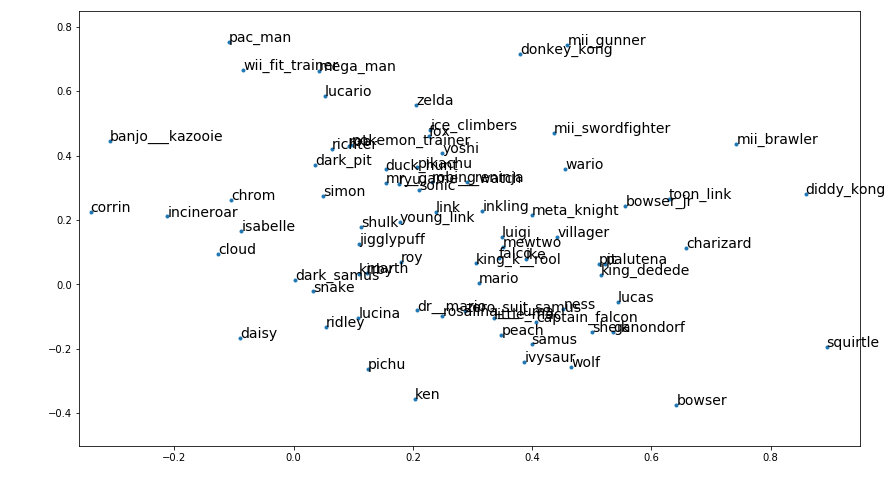

In [25]:
#plotting character "groupings"
plt.figure(figsize=(14,8))
plt.scatter(character_pca['PCA_1'], character_pca['PCA_2'], marker='.')
for i, word in enumerate(character_pca['Words']):
    plt.annotate(word, xy=(character_pca.iloc[i]['PCA_1'], character_pca.iloc[i]['PCA_2']), fontsize=14)
plt.xlim(-.36, .95)
plt.ylim(-.5, .85)

### Visualizing word2vec results using TSNE

In [26]:
charac_vects = []
for charac in character_list:
    charac_vects.append(model.wv[charac])

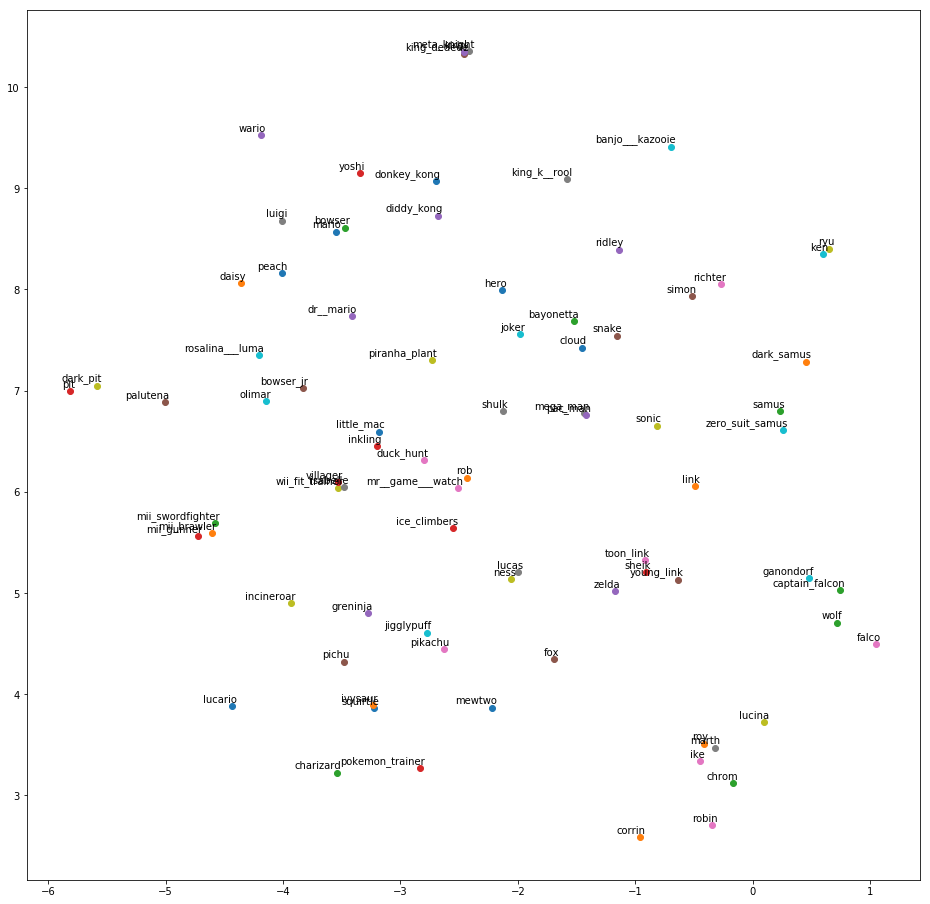

In [36]:
#print(charac_vects[0])

tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=256)
new_values = tsne_model.fit_transform(charac_vects)
x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(16, 16)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(character_list[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.show()

### Step 2: Corex

In [28]:
##count vectorizer
vectorizer = CountVectorizer(stop_words=stop_all, min_df=.0008, binary=True) #min_df=.0008, leave out

doc_word = vectorizer.fit_transform(lemm_posts)
words = list(np.asarray(vectorizer.get_feature_names()))

In [29]:
len(words)

4059

In [37]:
#vectorizer.vocabulary_

{'gatekeeper': 1443,
 'three': 3603,
 'houses': 1691,
 'smash': 3283,
 'please': 2670,
 'true': 3724,
 'hero': 1635,
 'entire': 1133,
 'game': 1429,
 'localize': 2080,
 'mother': 2323,
 'panel': 2554,
 'de': 855,
 'pon': 2696,
 'rather': 2855,
 'iconic': 1715,
 'line': 2058,
 'think': 3591,
 'pretty': 2745,
 'sure': 3497,
 'soldier': 3306,
 'guy': 1565,
 'deserves': 911,
 'better': 335,
 'fanboy': 1247,
 'png': 2675,
 'copy': 731,
 'forget': 1367,
 'always': 109,
 'somewhere': 3322,
 'someone': 3317,
 'fighting': 1303,
 'long': 2090,
 'remember': 2937,
 'alone': 96,
 'fight': 1299,
 'buddy': 453,
 'report': 2955,
 'deserving': 912,
 'even': 1160,
 'stands': 3400,
 'around': 190,
 'useless': 3804,
 'world': 3993,
 'gets': 1465,
 'done': 1000,
 'photobucket': 2613,
 'albums': 84,
 'metallic': 2245,
 'trance': 3693,
 'thanks': 3578,
 'works': 3992,
 'day': 849,
 'night': 2412,
 'making': 2155,
 'news': 2407,
 'professor': 2767,
 'kind': 1926,
 'soul': 3336,
 'peace': 2580,
 'share': 3187,

In [91]:
#took a bit under 5 mins 5k columns
topic_model = ct.Corex(n_hidden=len(character_list), words=words, seed=1)
topic_model.fit(doc_word, words=words, docs=df_posts)

In [92]:
#non anchored CorEx
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: smashfaqshi,dakimakura,honey,notok,tinfoil,senok,squidiot,mace,jkid,merp
1: linne,fz,mainer,hyde,seth,vegeta,ss,blazblue,cross,tag
2: attack,attacks,damage,hit,moves,air,opponent,kill,neutral,magic
3: jo,isa,amamiya,january,saki,touchdown,travis,smashfaqs,changing,started
4: away,fight,sword,slow,uses,discussionswitch,blow,head,weapon,hurt
5: boardsmy,viii,collection,jpg,hero,game
6: really,something,lot,good,thing,want,never,feel,else,especially
7: waluigi,boardmost,ravio,message,supporting,skull,hello,boys,australian,ohmygosh
8: ultimate,smash,official,board,boards,gamespot,robbed,gdi,bomberman,rojo
9: super,bros,dragon,quest,filming,ball,dqiv,production,solo,dr__mario
10: dee,bandana,chrom,bread,lucina,falco,fe,marth,roy,ganondorf
11: characters,point,make,sakurai,two,popular,said,already,fans,years
12: end,palmacosta,citizens,arleas,saluetes,escalate,subtle,initial,trolling,copy
13: hearts,fantasy,final,kingdom,cooking,disguise,forsaken,purchase,food,caring
14: occupy,sometimes,

ValueError: not enough values to unpack (expected 2, got 0)

In [35]:
#anchor Corex to create topic 
topic_model_anc2 = ct.Corex(n_hidden=len(character_list), words=words,
                       max_iter=200, verbose=False, seed=1)

topic_model_anc2.fit(doc_word, words=words, docs=df_posts, 
                anchors=character_list, anchor_strength=8)
#useless with ancor_strenght of 10

# Print all topics from the CorEx topic model
topics_char2 = topic_model_anc2.get_topics()
for n,topic in enumerate(topics_char2):
    topic_words_char2,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words_char2))

0: donkey_kong,stage,spirits,mode,music,boss,stages,spirit,tracks,bosses
1: dark_samus,characters,character,unique,moveset,roster,echo,added,add,potential
2: captain_falcon,attacks,attack,use,damage,move,hit,moves,air,falcon
3: ice_climbers,votes,closed,results,poll,ball,ashrah,mortal,restore,smoke
4: dr__mario
5: young_link,photobucket,albums,boardsban,trance,metallic,org,users,seek,sight
6: mr__game___watch,rex,robo,pyra,chibi,rhythm,heaven,crossing,elma,animal
7: meta_knight,racists,politics,claim,read
8: dark_pit,gay,meaning,mods
9: zero_suit_samus,umbrella,bell,explodes,covering,opened,decently,sending,wear
10: squirtle,cyoa,may,plot,enthusiasts,ping,dm,pirate,track,check
11: ivysaur,de,tumblr,des,annees,sur,reposent,recherche,propos,segalization
12: charizard,take,power,seriously,alive,anyway,nobody,fight,greater,help
13: pokemon_trainer,secondaries
14: diddy_kong,disguise,purchase,cooking,food,fast,lullabys,sings,windows,sky
15: king_dedede
16: toon_link,carbon,copies,viridiuser